In [42]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

### Dataset

In [43]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: 0.0


In [44]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [45]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [46]:
# Hyperparameters
learning_rate = .0192
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [47]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:03<00:00, 235.81it/s]


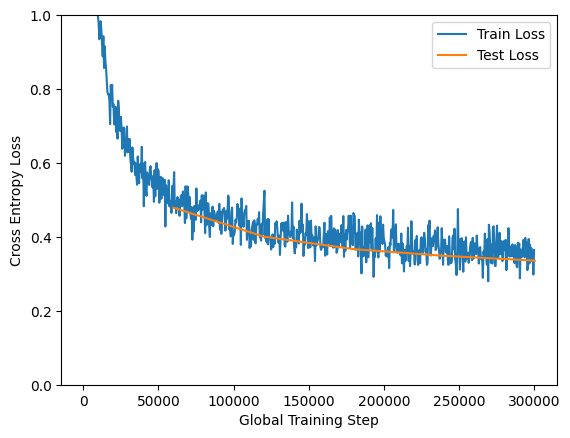

Final Test loss: 0.33583178549150755. Final Test accuracy: 0.9084


In [48]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task A

In [49]:
batch_size = 64
learning_rate = .0192
num_epochs = 5

image_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)

image_transform_normalized = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

dataloader_train_normalized, dataloader_test_normalized = dataloaders.load_dataset(
    batch_size, image_transform_normalized)

model = create_model()

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
)

trainer_normalized = Trainer(
    model=model,
    dataloader_train=dataloader_train_normalized,
    dataloader_test=dataloader_test_normalized,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
)

print("Without normalization: \n")
train_loss, test_loss = trainer.train(num_epochs)

print("With normalization: \n")
train_loss_normalized, test_loss_normalized = trainer_normalized.train(
    num_epochs)


Without normalization: 



Training epoch 4: 100%|██████████| 938/938 [00:04<00:00, 213.61it/s]


With normalization: 



Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 126.11it/s]


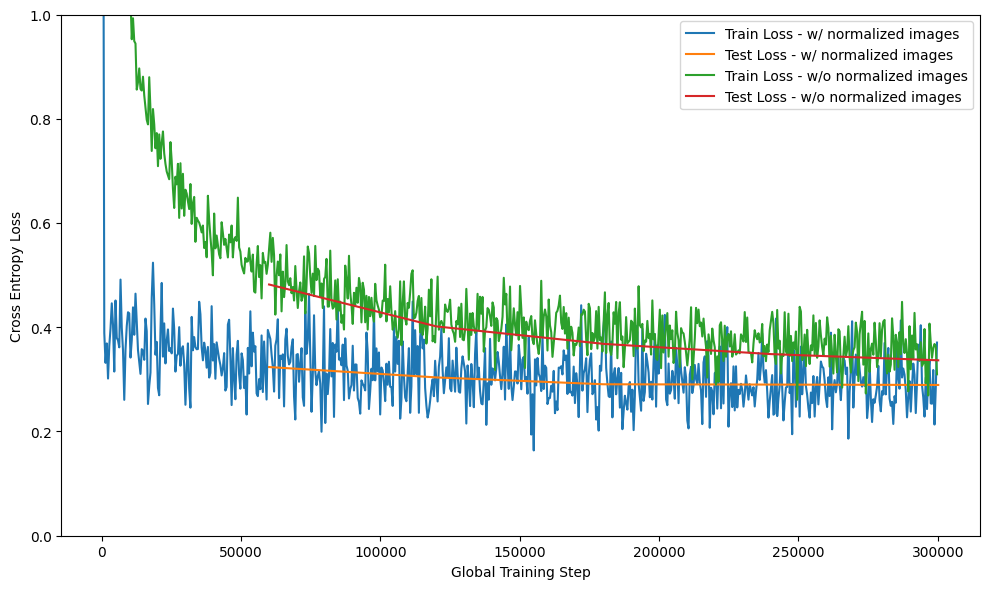

In [50]:
utils.plot_loss(train_loss_normalized,
                label="Train Loss - w/ normalized images")
utils.plot_loss(test_loss_normalized,
                label="Test Loss - w/ normalized images")
utils.plot_loss(train_loss, label="Train Loss - w/o normalized images")
utils.plot_loss(test_loss, label="Test Loss - w/o normalized images")

plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")

fig = plt.gcf().set_size_inches(10, 6)
plt.tight_layout()

plt.savefig("image_solutions/task_4a.png")

plt.show()


### Task B

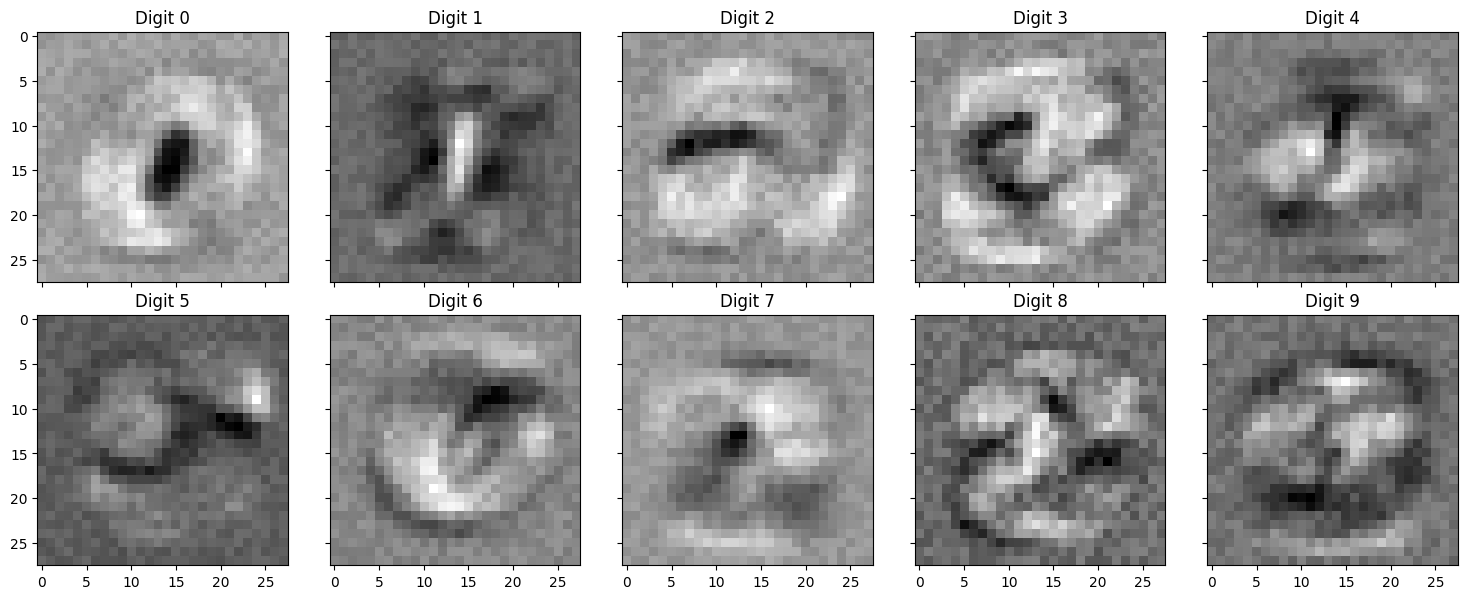

In [51]:
weight = list(model.children())[1].weight.cpu().data

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(15, 6))
for i in range(10):
    axes[i // 5, i % 5].imshow(weight[i].reshape((28, 28)), cmap="gray")
    axes[i // 5, i % 5].set_title(f"Digit {i}")
fig.tight_layout()
fig.savefig("image_solutions/task_4b.png")


### Task C

In [52]:
learning_rate = 1.0

image_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)

model = create_model()

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
)

train_loss_lr1, test_loss_lr1 = trainer.train(num_epochs)


Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 130.02it/s]


Final Test loss: 2.0404681219531624. Final Test accuracy: 0.9041


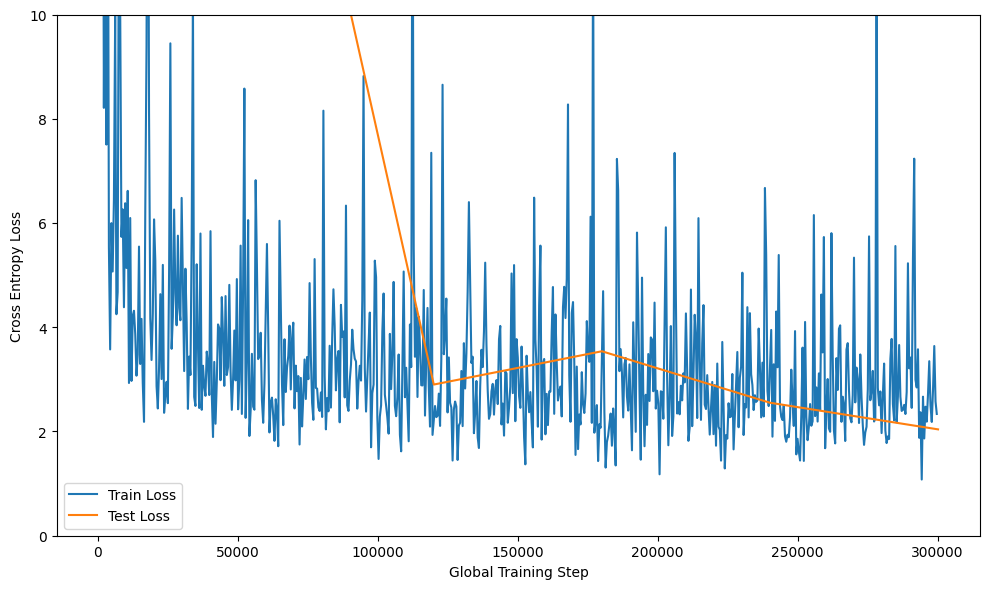

In [53]:
utils.plot_loss(train_loss_lr1, label="Train Loss")
utils.plot_loss(test_loss_lr1, label="Test Loss")
plt.ylim([0, 10])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")

fig = plt.gcf().set_size_inches(10, 6)
plt.tight_layout()

plt.savefig("image_solutions/task_4c.png")

final_loss, final_accuracy = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function
)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_accuracy}")

plt.show()


### Task D

In [32]:
learning_rate = 0.0192

image_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)
model = utils.to_cuda(model)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)

train_loss_deep, test_loss_deep = trainer.train(num_epochs)


Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 119.37it/s]


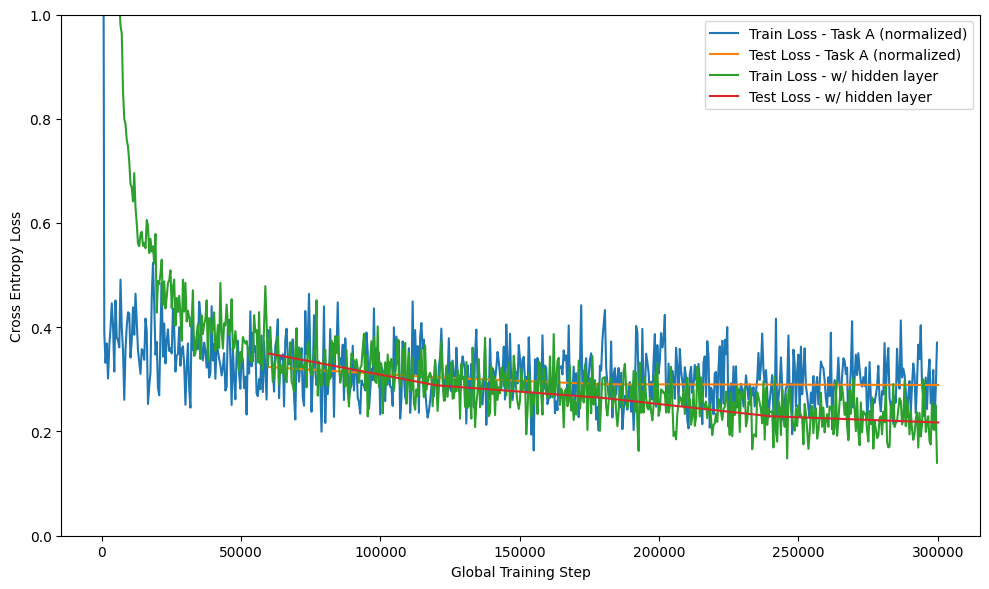

In [54]:
utils.plot_loss(train_loss_normalized, label="Train Loss - Task A (normalized)")
utils.plot_loss(test_loss_normalized, label="Test Loss - Task A (normalized)")
utils.plot_loss(train_loss_deep, label="Train Loss - w/ hidden layer")
utils.plot_loss(test_loss_deep, label="Test Loss - w/ hidden layer")

plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")

fig = plt.gcf().set_size_inches(10, 6)
plt.tight_layout()

plt.savefig("image_solutions/task_4d.png")

plt.show()